In [4]:
import numpy as np
import matplotlib.pyplot as plt

from pycircstat2 import Circular, load_data
from pycircstat2.clustering import MoVM
from pycircstat2.visualization import circ_plot

# Clustering circular data with a mixture of von Mises distributions

Here we use the dataset B3 from Fisher (1993) to demonstrate the usage of MoVM (Mixture of von Mises), as it's also the example shown in Jammalamadaka & Vaidyanathan (2024). 

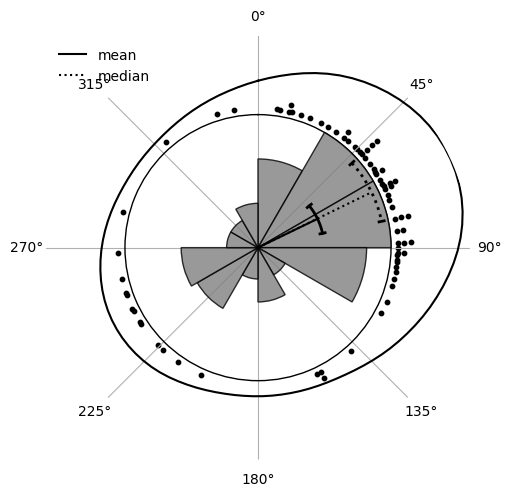

In [3]:
d = load_data("B3", source="fisher")["θ"].values
c = Circular(d)
_ = circ_plot(c)